In [133]:
import math
import numpy as np
import scipy 
import scipy.stats as sts
import matplotlib
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

# Tutorial 1

## Introduction

In the first tutorial of Module 3, we will implement a simple probabilistic population code, performing Bayes-optimal multisensory integration given some simple assumptions. We will encode the heading direction of a subject in two neural populations with Poisson variability, then integrate the information from these populations to calculate the posterior through a simple application of Bayes' rule.


## Exercise 1
First we will simulate population responses representing heading direction in the visual and vestibular system. We will assume Bell-shaped (Gaussian) tuning curves, with different gains for each population, and Poisson variability.

Write a function to generate, given an angle, the response rates in the visual and vestibular populations, with 30 neurons each. Neurons in each population should have equally spaced preferred stimuli between 0 and 180 degrees, and otherwise identical tuning curves $f_i(s)$. You are welcome to experiment with different values for the gains and for the standard deviation that defines the shape of the tuning curves, or you can use the following:  $g_{vi}=40$, $g_{ve}=80$, and $\sigma=40$.

Then write a function that generates spike counts for these populations, using independent Poisson variability.

$\displaystyle p(\mathbf r \rvert s)=\prod_{i=1}^{N} p(r_i \rvert s)=\prod_{i=1}^{N}\frac{e^{-gf_{i}(s)}(g \cdot f_i(s))^r}{r_i!}$

Plot these spike counts for the two populations for an input of 80$^{\circ}$.

<img src="spikes_11.png">


In [134]:
g_vi, g_ve = 40, 80

In [135]:
def spike_count(s, i, g):
    return np.random.poisson(lam = g * firing_rate(s, i))

In [136]:
def firing_rate(s, i):
    return sts.norm.pdf(s, loc = i * 6, scale = 40)

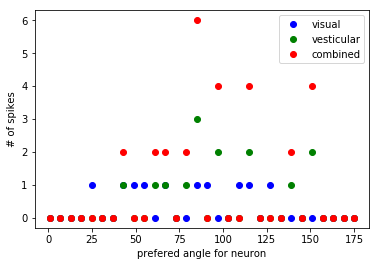

In [137]:
s = 80
stimuli = range(1, 180, 6)
spike_vi = [spike_count(s, i, g_vi) for i in range(30)]
spike_ve = [spike_count(s, i, g_ve) for i in range(30)]
plt.plot(stimuli, spike_vi, "bo", label = "visual")
plt.plot(stimuli, spike_ve, "go", label = "vesticular")
plt.plot(stimuli, np.array(spike_ve) + np.array(spike_ve), "ro", label = "combined")
plt.legend()
plt.ylabel("# of spikes")
plt.xlabel("prefered angle for neuron")
plt.show()

## Exercise 2
Write a function to calculate the (discretized) posterior over possible heading directions: 
\begin{eqnarray}
p(s\rvert \mathbf r) \propto exp\Big( \sum_{i}\big( -g \cdot f_i(s)+r_i \cdot \log\ f_i(s)\big) \Big),
\end{eqnarray}
separately for each of our neural populations. Then perform optimal cue integration by adding up the activity from the two populations $\mathbf r_{com} =\mathbf r_{ve}+\mathbf r_{vi}$, and use it to calculate the joint posterior $p(s\rvert \mathbf r_{ve},\mathbf r_{vi})$. To derive the formula for this posterior, simply note that because of conditional independence given s, $p(s\rvert \mathbf r_{ve},\mathbf r_{vi})=p(s\rvert \mathbf r_{vi})p(s\rvert \mathbf r_{ve})$

Use a discretization of at least 100 points for the range of 0$^{\circ}$ to 180$^{\circ}$ of potential heading directions.

Plot the resulting posteriors. Also estimate (numerically) the variance of each posterior distribution, and confirm the analytical relationship $\frac{1}{\sigma_{com}^2}=\frac{1}{\sigma_{ve}^2}+\frac{1}{\sigma_{vi}^2}$.

<img src="posteriors_2.png">

In [212]:
def posterior(r, s, g):
    p = np.exp(np.sum(-g * firing_rate(s, i) + r[i] * np.log(g * firing_rate(s, i)) for i in range(30)))
    return p

In [208]:
def statistics(x, y):
    p = y / sum(y)
    mu = sum(p[i] * x[i] for i in range(len(x)))
    sigma = np.sqrt(sum(p[i] * (x[i] - mu)**2 for i in range(len(x))))
    return mu, sigma

In [209]:
def decoder(s, g_ve = 80 , g_vi = 40):
    stimuli = range(1, 180, 6)
    spike_ve = [spike_count(s, i, g_ve) for i in range(30)]
    spike_vi = [spike_count(s, i, g_vi) for i in range(30)]
    stimuli = range(1, 180, 2)
    posterior_density_ve = np.array([posterior(spike_ve, s, g_ve) for s in stimuli])
    posterior_density_ve /= np.sum(posterior_density_ve)
    posterior_density_vi = np.array([posterior(spike_vi, s, g_vi) for s in stimuli])
    posterior_density_vi /= np.sum(posterior_density_vi)
    posterior_density_combined = posterior_density_vi * posterior_density_ve
    posterior_density_combined /= np.sum(posterior_density_combined)
    mu_combined = statistics(stimuli, posterior_density_combined)[0]
    mu_ve = statistics(stimuli, posterior_density_ve)[0]
    mu_vi = statistics(stimuli, posterior_density_vi)[0]
    return mu_combined, mu_ve, mu_vi

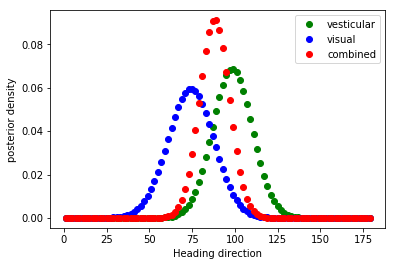

In [211]:
stimuli = range(1, 180, 2)
posterior_density_ve = np.array([posterior(spike_ve, s, g_ve) for s in stimuli])
posterior_density_ve /= np.sum(posterior_density_ve)
posterior_density_vi = np.array([posterior(spike_vi, s, g_vi) for s in stimuli])
posterior_density_vi /= np.sum(posterior_density_vi)
posterior_density_combined = posterior_density_vi * posterior_density_ve
posterior_density_combined /= np.sum(posterior_density_combined)

plt.plot(stimuli, posterior_density_ve, "go", label = "vesticular")
plt.plot(stimuli, posterior_density_vi, "bo", label = "visual")
plt.plot(stimuli, posterior_density_combined, "ro", label = "combined")
plt.xlabel("Heading direction")
plt.ylabel("posterior density")
plt.legend()
plt.show()

In [187]:
sigma_ve = statistics(stimuli, posterior_density_ve)[1]
sigma_vi = statistics(stimuli, posterior_density_vi)[1]
sigma_combined = statistics(stimuli, posterior_density_combined)[1]
print(1 / sigma_ve**2 + 1 / sigma_vi**2, 1 / sigma_combined**2)

(0.012936626482714313, 0.013133427613446606)


Your function should also return an estimate of the angle, such as the posterior mean or the maximum a posteriori (MAP) estimate (these are equal for a Gaussian posterior, but may differ numerically-which one do you think is better in this case?) for each population given an input, and the corresponding estimation error. Run 100 trails with random input angles and compare the total errors when using the separate and combined populations.

Then change your code s.t. the same stimulus is presented repeatedly for a hundred trials, and estimate the variance of your stimulus estimate for each population. Confirm that the same relationship holds for the trail to trial fluctuations of the estimate as for the variances of the single-trial posterior.   

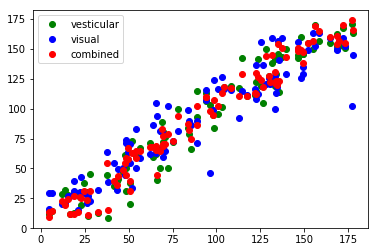

In [197]:
stimuli = np.random.uniform(0, 180, size = (100,))
stimuli_decoded = [decoder(s) for s in stimuli]

stimuli_decoded_ve = [x[1] for x in stimuli_decoded]
stimuli_decoded_vi = [x[2] for x in stimuli_decoded]
stimuli_decoded_combine = [x[0] for x in stimuli_decoded]

plt.plot(stimuli, stimuli_decoded_ve, "go", label = "vesticular")
plt.plot(stimuli, stimuli_decoded_vi, "bo", label = "visual")
plt.plot(stimuli, stimuli_decoded_combine, "ro", label = "combined")
plt.legend()

In [200]:
stimuli = 90 * np.ones((100))
stimuli_decoded = [decoder(s) for s in stimuli]

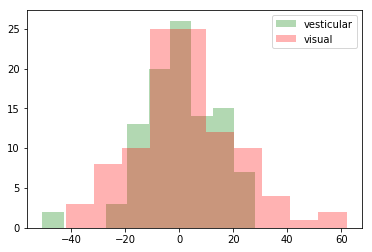

In [206]:
stimuli_decoded_ve = [x[1] for x in stimuli_decoded]
stimuli_decoded_vi = [x[2] for x in stimuli_decoded]
stimuli_decoded_combine = [x[0] for x in stimuli_decoded]

plt.hist(stimuli_decoded_ve - stimuli, label = "vesticular", color = "green", alpha = 0.3)
plt.hist(stimuli_decoded_vi - stimuli, label = "visual", color = "red", alpha = 0.3)
plt.legend()
plt.show()

## Exercise 3

In real brains, variability is often neither exactly Poisson, nor is it independent between neurons, and tuning curves might not be matched exactly between brain regions and neurons. However, a simple linear scheme for representing a joint posterior without loss of information can still be implemented, if certain conditions on the tuning curves and the noise covariance are met. 

In particular we will consider the case of Poisson like variability, where the noise is from the exponential family with linear sufficient statistics:

$p(\mathbf r\rvert s)=\frac{\Psi(\mathbf r)}{\eta (s)}e^{\mathbf h(s) \cdot \mathbf r}$. (Here $\eta (s)$ serves to normalize the distribution.)

Then it can be shown, that in this case
$\mathbf h^{'}(s)=\Sigma^{-1}(s)\cdot\mathbf f^{'}(s)$

In our first example we had $h_i(s)=\log f_i(s)$, with identical tuning curves for our two input populations, and a diagonal covariance matrix. More generally, the necessary conditions will still be met if the tuning curves can be linearly mapped on to a common basis of tuning functions, s.t.
$\mathbf h_{vi}(s)=\mathbf W_{vi}\mathbf H(s)$ and $\mathbf h_{ve}(s)=\mathbf W_{ve}\mathbf H(s)$. 

Then the linear combination $\mathbf r_{com} = \mathbf{W_{vi}^{T}r_{vi}+W_{ve}^{T}r_{ve}}$.

Choose a basis H(s) (you could choose e.g. a set of basis functions that is a mix of log Gaussian and log sigmoid functions), and check if you still get a better readout of the combined populations if you rerun the experiments form the previous exercises, using sparse loading weight matrices $\mathbf W$.






